In [7]:
import pandas as pd, numpy as np, json, os
from pathlib import Path

# Load dataset (project root is CWD)
df = pd.read_csv("../data/cleaned_ids2018_sampled.csv", low_memory=False)
print("Loaded:", df.shape)


Loaded: (1252846, 79)


In [8]:
# Ensure Label column is read as string
df['Label'] = df['Label'].astype(str)

# Create binary column: 0 = benign, 1 = attack
df['is_attack'] = (df['Label'].str.lower() != 'benign').astype(int)

print(df['Label'].value_counts().head())
print(df[['Label','is_attack']].head())


Label
1    971016
4    137185
5     57507
2     38703
3     37323
Name: count, dtype: int64
  Label  is_attack
0     1          1
1     1          1
2     1          1
3     1          1
4     1          1


In [9]:
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'Label']  # keep Label for now

for c in cat_cols:
    if df[c].nunique() < 500:   # tune threshold
        df[c] = df[c].fillna("nan_missing")
        df[c] = LabelEncoder().fit_transform(df[c].astype(str))
    else:
        # if a very high-cardinality string-like column, drop it (or treat differently)
        df = df.drop(columns=[c])
        print(f"DROPPED high-cardinality column: {c}")


In [10]:
from sklearn.model_selection import train_test_split

feature_cols = [c for c in df.columns if c not in ('Label','is_attack')]
X = df[feature_cols]
y = df['is_attack']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1002276, 78) Test shape: (250570, 78)


              precision    recall  f1-score   support

           1       1.00      1.00      1.00    250570

    accuracy                           1.00    250570
   macro avg       1.00      1.00      1.00    250570
weighted avg       1.00      1.00      1.00    250570



C:\Users\Antonio\smart-incident-dashboard\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


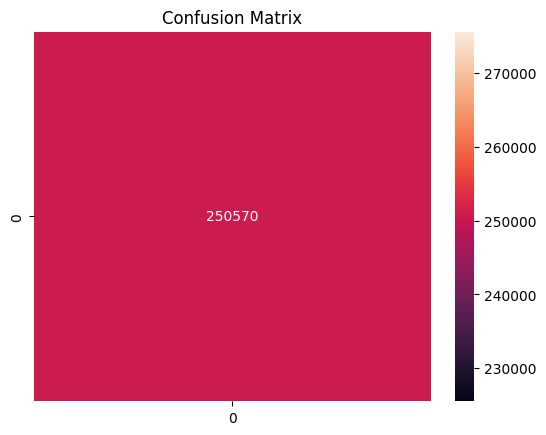

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42))
])

pipe.fit(X_train, y_train)

# preds + metrics
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))
import matplotlib.pyplot as plt, seaborn as sns
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


In [12]:
import joblib
from pathlib import Path, PurePath
p = Path("models")
p.mkdir(exist_ok=True)

model_path = p / "rf_pipeline.joblib"
joblib.dump(pipe, model_path)
print("Saved model to", model_path)

# Save expected feature order so API can reconstruct input columns
feature_file = p / "feature_names.json"
import json
with open(feature_file, "w") as f:
    json.dump(feature_cols, f)
print("Saved feature names to", feature_file)


Saved model to models\rf_pipeline.joblib
Saved feature names to models\feature_names.json
